<a href="https://colab.research.google.com/github/Himanshu069/dgcnn_implementation/blob/main/dgcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import os
import shutil

himanshupaudel_modelnet40_path = kagglehub.dataset_download('himanshupaudel/modelnet40')

print('Data source import complete.')


In [ ]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.checkpoint as checkpoint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
#import torch_xla
#import torch_xla.core.xla_model as xm
#import torch_xla.utils.utils as xu

# Define the directory where the files are located
DATA_DIR = '/kaggle/input/modelnet40/modelnet40_hdf5_2048'




def load_training_data():
    all_data = []
    all_labels = []

    # Loop through the HDF5 files (train0.h5 to train4.h5)
    for i in range(5):
        h5_filename = os.path.join(DATA_DIR, f'train{i}.h5')

        # Check if the file exists before trying to open it
        if os.path.exists(h5_filename):
            print(f"Loading file: {h5_filename}")
            try:
                with h5py.File(h5_filename, 'r') as f:
                    data = f['data'][:].astype('float32')  # Load data
                    labels = f['label'][:].astype('int64')  # Load labels
                    all_data.append(data)
                    all_labels.append(labels)
            except Exception as e:
                print(f"Error loading file {h5_filename}: {e}")
        else:
            print(f"File {h5_filename} does not exist!")

    # Concatenate all loaded data and labels into single arrays
    if all_data:
        all_data = np.concatenate(all_data, axis=0)
    if all_labels:
        all_labels = np.concatenate(all_labels, axis=0)

    return all_data, all_labels

def load_test_data():
    all_data = []
    all_labels = []

    # Loop through the HDF5 files (test0.h5, test1.h5)
    for i in range(2):
        h5_filename = os.path.join(DATA_DIR, f'test{i}.h5')

        # Check if the file exists before trying to open it
        if os.path.exists(h5_filename):
            print(f"Loading file: {h5_filename}")
            try:
                with h5py.File(h5_filename, 'r') as f:
                    data = f['data'][:].astype('float32')  # Load data
                    labels = f['label'][:].astype('int64')  # Load labels
                    all_data.append(data)
                    all_labels.append(labels)
            except Exception as e:
                print(f"Error loading file {h5_filename}: {e}")
        else:
            print(f"File {h5_filename} does not exist!")

    # Concatenate all loaded data and labels into single arrays
    if all_data:
        all_data = np.concatenate(all_data, axis=0)
    if all_labels:
        all_labels = np.concatenate(all_labels, axis=0)

    return all_data, all_labels

# Usage example for loading training data
train_data, train_labels = load_training_data()

# Check the shapes of the loaded training data and labels
if train_data.size > 0 and train_labels.size > 0:
    print("Training data shape:", train_data.shape)
    print("Training labels shape:", train_labels.shape)
else:
    print("Training data or labels are empty!")


Loading file: /kaggle/input/modelnet40/modelnet40_hdf5_2048/train0.h5
Loading file: /kaggle/input/modelnet40/modelnet40_hdf5_2048/train1.h5
Loading file: /kaggle/input/modelnet40/modelnet40_hdf5_2048/train2.h5
Loading file: /kaggle/input/modelnet40/modelnet40_hdf5_2048/train3.h5
Loading file: /kaggle/input/modelnet40/modelnet40_hdf5_2048/train4.h5
Training data shape: (9843, 2048, 3)
Training labels shape: (9843, 1)


In [ ]:

def intermediate(x, xx):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    torch.cuda.empty_cache()
    return -xx - inner

def knn(x, k):
    x = x.to(torch.float16)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    #print("shape of x and xx",x.shape,xx.shape)
    pairwise_distance = intermediate(x, xx) - xx.transpose(2, 1)
    torch.cuda.empty_cache()
    #print("k and pairwise distance", k, pairwise_distance.shape)
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx

def get_graph_feature(x, k=20, idx=None,dim9=False):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        if dim9 == False:
            idx = knn(x, k=k)   # (batch_size, num_points, k)
        else:
            idx = knn(x[:, 6:], k=k)
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)

    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims)
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)

    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()

    return feature



class DGCNN(nn.Module):
    def __init__(self, num_classes, input_dims, k=20, emb_dims=1024, dropout=0.5):
        super(DGCNN, self).__init__()
        self.num_classes = num_classes
        self.input_dims = input_dims
        self.k = k
        self.emb_dims = emb_dims
        self.dropout = dropout

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm1d(self.emb_dims)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),
                                   self.bn1,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn2,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 128, kernel_size=1, bias=False),
                                   self.bn3,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(128*2, 256, kernel_size=1, bias=False),
                                   self.bn4,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512, self.emb_dims, kernel_size=1, bias=False),
                                   self.bn5,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.linear1 = nn.Linear(self.emb_dims*2, 512, bias=False)
        self.bn6 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout(p=self.dropout)
        self.linear2 = nn.Linear(512, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(p=self.dropout)
        self.linear3 = nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x1 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x1, k=self.k)
        x = self.conv2(x)
        x2 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x2, k=self.k)
        x = self.conv3(x)
        x3 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x3, k=self.k)
        x = self.conv4(x)
        x4 = x.max(dim=-1, keepdim=False)[0]

        x = torch.cat((x1, x2, x3, x4), dim=1)

        x = self.conv5(x)
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)
        x = torch.cat((x1, x2), 1)

        x = F.leaky_relu(self.bn6(self.linear1(x)), negative_slope=0.2)
        x = self.dp1(x)
        x = F.leaky_relu(self.bn7(self.linear2(x)), negative_slope=0.2)
        x = self.dp2(x)
        x = self.linear3(x)
        return x

In [ ]:
'''import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met

# Print the device information to confirm TPU is being used
device = xm.xla_device()
print(f"Using device: {device}")
print(met.metrics_report())'''


'import torch_xla.core.xla_model as xm\nimport torch_xla.debug.metrics as met\n\n# Print the device information to confirm TPU is being used\ndevice = xm.xla_device()\nprint(f"Using device: {device}")\nprint(met.metrics_report())'

In [ ]:
#device = xm.xla_device()

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = DGCNN(40,3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)




class DDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


point_clouds=[]
labels=[]

train_input, train_output = load_training_data()

train_dataset = DDataset(train_input, train_output)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
num_epochs = 10
train_accuracies = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0.0
    total = 0.0
    train_accuracy = 0.0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(data.permute(0,2,1))
        labels = labels.squeeze()
        loss = F.cross_entropy(output, labels)
        loss.backward()
        optimizer.step()
        #xm.optimizer_step(optimizer)
        running_loss += loss.item()
        #xm.mark_step()
        #print(loss)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    print(f"epoch {epoch + 1}, Average Loss: {running_loss/len(train_loader):.4f}, Train accuracy:{train_accuracy:.2f}%")

#def evaluate_model(model, dataloader):
model.eval()
test_input, test_output = load_test_data()
test_dataset = DDataset(test_input, test_output)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

all_preds = []
all_labels = []
correct1 = 0.0
total1 = 0.0
test_accuracies = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs.permute(0, 2, 1))

        _, predicted = torch.max(outputs, 1)

        # Update total and correct predictions count
        total1 += labels.size(0)
        correct1 += (predicted == labels).sum().item()

        # Optionally store predictions and labels for further analysis
        # all_preds.append(predicted.cpu().numpy())
        # all_labels.append(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = 100 * correct1 / total1
test_accuracies.append(test_accuracy)

# Optionally concatenate predictions and labels for additional analysis
# all_preds = np.concatenate(all_preds)
# all_labels = np.concatenate(all_labels)

# Print the test accuracy
#print(f'Accuracy: {test_accuracy:.2f}%')






#evaluate_model(model, test_loader)



cuda
Loading file: /kaggle/input/modelnet40/modelnet40_hdf5_2048/train0.h5
Loading file: /kaggle/input/modelnet40/modelnet40_hdf5_2048/train1.h5
Loading file: /kaggle/input/modelnet40/modelnet40_hdf5_2048/train2.h5
Loading file: /kaggle/input/modelnet40/modelnet40_hdf5_2048/train3.h5
Loading file: /kaggle/input/modelnet40/modelnet40_hdf5_2048/train4.h5
epoch 1, Average Loss: 1.4288, Train accuracy:61.61%
epoch 2, Average Loss: 0.8157, Train accuracy:75.69%
epoch 3, Average Loss: 0.6673, Train accuracy:79.64%
epoch 4, Average Loss: 0.6017, Train accuracy:81.03%
epoch 5, Average Loss: 0.5482, Train accuracy:82.84%
epoch 6, Average Loss: 0.4915, Train accuracy:84.48%
epoch 7, Average Loss: 0.4893, Train accuracy:84.51%
epoch 8, Average Loss: 0.4509, Train accuracy:85.60%
epoch 9, Average Loss: 0.4374, Train accuracy:85.75%
epoch 10, Average Loss: 0.4374, Train accuracy:86.11%
Loading file: /kaggle/input/modelnet40/modelnet40_hdf5_2048/test0.h5
Loading file: /kaggle/input/modelnet40/modeln

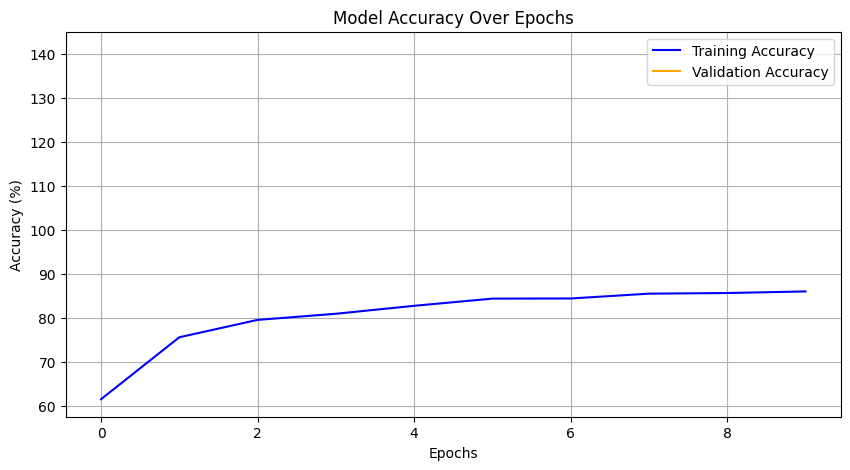

In [ ]:
import matplotlib.pyplot as plt

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(test_accuracies, label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()
